In [1]:
# This code to link colab to a drive account
from google.colab import drive
drive.mount('/content/drive/')

import os
code_dir = '/content/drive/My Drive/new_classifier_template'   # Change this according to your directory
try:
    os.chdir(code_dir)
except Exception as e:
    print(e)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install import-ipynb   # it is necessary to import functions and classes from other notebooks directly
# General
import import_ipynb
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import tarfile

# The current template
from pytorch_device_manager import  DeviceManager # To get info about the available device to train on
from evaluation_metrics import ClassifierReport
from pytorch_dataset_preparation import PytorchDatasetPreparation
from pytorch_model_training import ModelInitializer, ModelTraining
from utilities import ElapsedTime

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau, MultiStepLR


importing Jupyter notebook from pytorch_device_manager.ipynb
importing Jupyter notebook from evaluation_metrics.ipynb


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

Importing Done ...
importing Jupyter notebook from pytorch_dataset_preparation.ipynb
importing Jupyter notebook from utilities.ipynb
Importing Done ...
importing Jupyter notebook from pytorch_model_training.ipynb
importing Jupyter notebook from pytorch_data_transformation.ipynb


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Importing Done ...


In [3]:
# Device information
dvc_mng = DeviceManager()
dvc_mng.available_gpus_info()
device = dvc_mng.get_gpu_device(0)

Number of GPUs :  1 

* GPU index : 0 	 GPU name : Tesla T4 	 RAM : 15.812 [GB] 



In [4]:
# Load the dataset and dataset description
dataset_dir = 'hymenoptera_data'   # Dataset directory
show_images_dims_summary = True
batch_size = 4
num_workers = 0

data_splitting_parameters = {
    
    'validation_ratio': 0.2,
    'splitting_random_state': 1,
    'stratified': True
}

data_loading_parameters = {
    'training_batch_size': batch_size,
    'validation_batch_size': batch_size,
    
    'training_shuffle': True,
    'validation_shuffle': False,
    
    'training_num_workers': num_workers,
    'validation_num_workers': num_workers,
    
    'training_pin_memory': True,
    'validation_pin_memory': True,
    
    'training_sampler_class': None,#ImbalancedDatasetSampler, # Could be None
    'training_sampler_parameters': {'data_source': True, 'indices':None, 'num_samples':400},
}

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the dataset
dataset = PytorchDatasetPreparation(dataset_dir = dataset_dir,
                                    splitting_parameters = data_splitting_parameters,
                                    loading_parameters = data_loading_parameters,
                                    data_transforms = data_transforms,
                                    show_images_dims_summary = show_images_dims_summary)
dataset

Check the minimum and maximum image dimensions: 100%|██████████| 397/397 [00:00<00:00, 60791.45it/s]

Done


* Root directory : 
/content/drive/My Drive/new_classifier_template/hymenoptera_data

* Classes details : 
Number of classes : 2
Available classes : {'ants': 0, 'bees': 1}

* Images dimensions details : 
Minimum width : 193 
Average width : 490 
Maximum width : 2592 

Minimum height : 130 
Average height : 392 
Maximum height : 1984 


* Dataset
** Extensions details : 
Available extensions : ['.jpg']
Number of samples per extension : 
.jpg    397
dtype: int64

** Samples details : 
Number of samples : 397
Number of samples per class and per extension : 
            class_name number_of_samples .jpg
class_index                                  
0                 ants               193  193
1                 bees               204  204
Classes percentages : [0.486 0.514]
Classes weights : [2.058 1.946]


* Training Dataset
** Extensions details : 
Available extensions : ['.jpg']
Number of samples per extension : 
.jpg    317
dtype: int64

** Samples details : 
Number of samples : 317
Nu

In [5]:
# Define your Model (Refer to ModelInitializer to know all the available models)
model_name = 'resnet18'
model_initializer = ModelInitializer(model_name = model_name, 
                                     use_pretrained = True, 
                                     update_head = {'update': True,
                                                    'init_mode': None,
                                                    'val': None}, 
                                     num_classes = dataset.number_of_classes,
                                     dropout = {'add_dropout': False, 'prob': 0.5})

# Get a model (All layers are non trainble)
model = model_initializer.get_model()
ModelInitializer.update_trainability([model.fc], trainable = True)
model.fc.bias

Parameter containing:
tensor([-0.0285,  0.0271], requires_grad=True)

In [0]:
# Loss function 
loss_function = nn.CrossEntropyLoss()

# Optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Scheduler
scheduler = MultiStepLR(optimizer, milestones=[5, 40, 80], gamma=0.1)

# Epoch
num_epochs = 10

In [0]:
model_training = ModelTraining(model = model,
                               model_name = model_name,
                               device = device,
                               loss_function = loss_function,
                               optimizer = optimizer,
                               scheduler =scheduler,
                               num_epochs = num_epochs,
                               input_type={'train': 'single_crop','validation': 'single_crop'})


In [8]:
# General memory info
model_training.model_memory_size(bits = 32)


model size 45.0 MB
number of all trainable parametesrs: 11177538
number of current trainable parametesrs: 1026


In [9]:
# Get the memory consumption for each stage during the training
model_training.model_memory_utilization( batch_size=64, dim=(224, 224))

Data Transfer reserved 38.536 [MB] GPU RAM
Zero gradients reserved 0.0 [MB] GPU RAM
Forward reserved 0.132 [MB] GPU RAM
Prediction reserved 0.001 [MB] GPU RAM
Loss reserved 0.002 [MB] GPU RAM
Backward reserved -0.127 [MB] GPU RAM
Optimizor reserved 0.009 [MB] GPU RAM


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


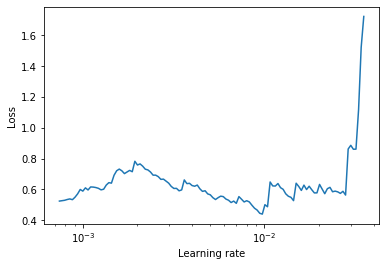

In [10]:
# For more information refer to https://github.com/davidtvs/pytorch-lr-finder
# If you want to find the best learning rate
model_training.find_best_learning_rate(dataset, num_iter=300,
                                       use_val_loss = False, end_lr = 10, step_mode='exp')

Epoch 10/10
Current learning rate: 5e-05 
Training
Confusion Matrix



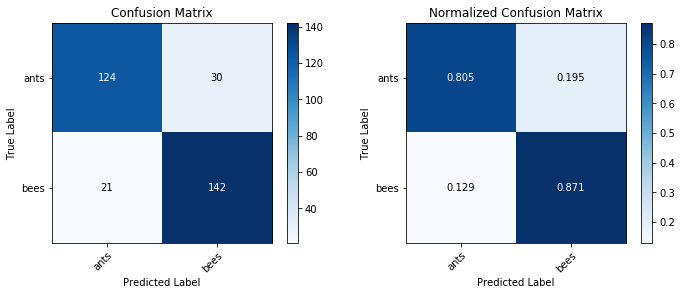


Confusion Tables



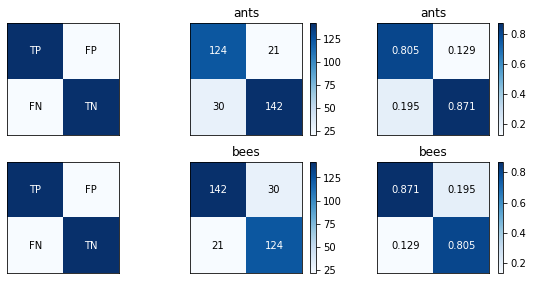


Overall Metrics



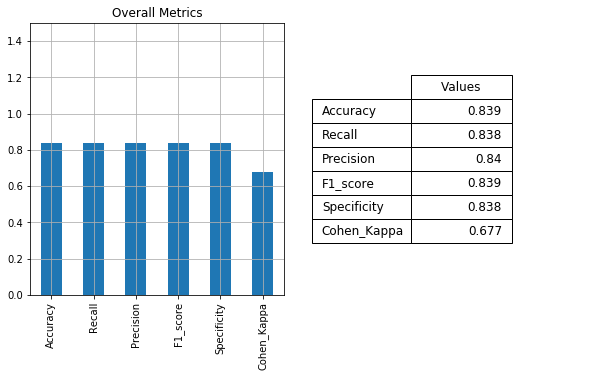


Classes Metrics



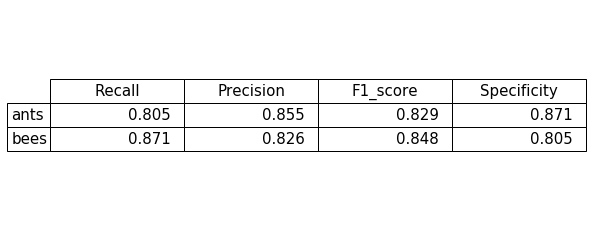

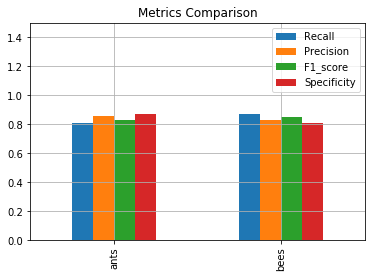

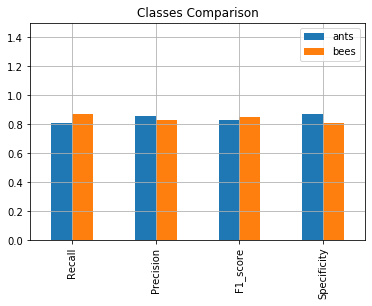


ROC Curve



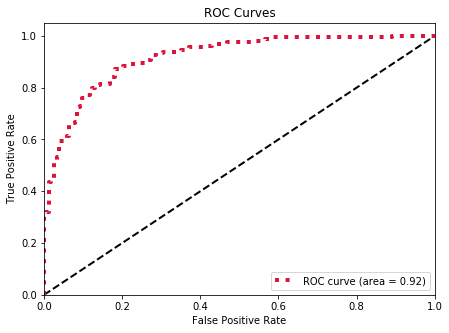

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Validation
Confusion Matrix



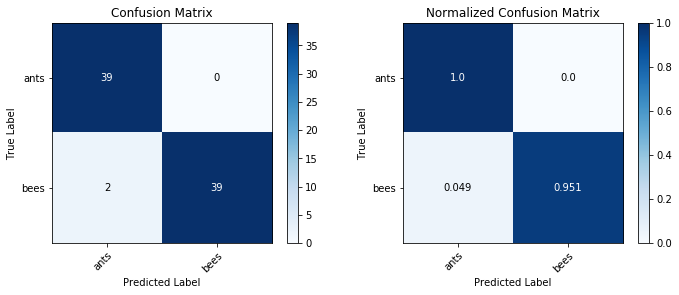


Confusion Tables



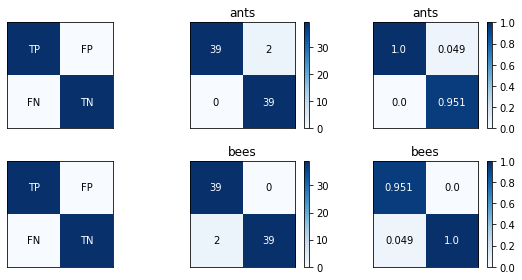


Overall Metrics



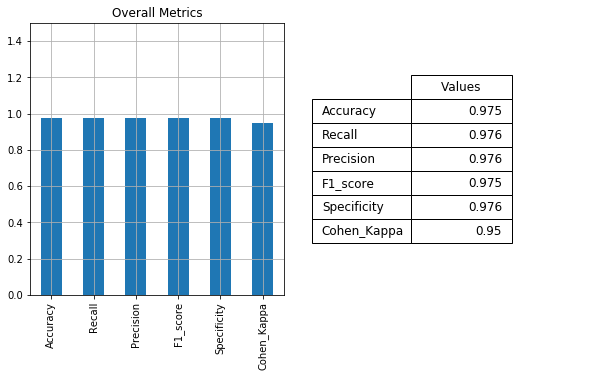


Classes Metrics



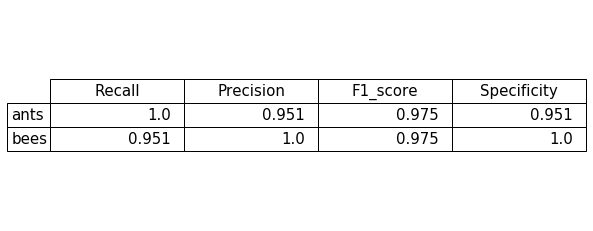

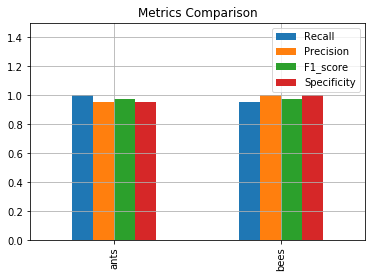

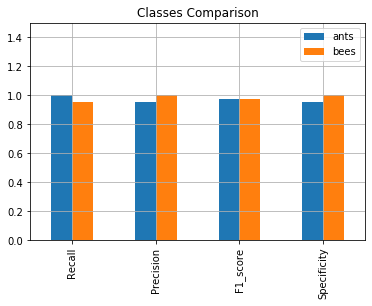


ROC Curve



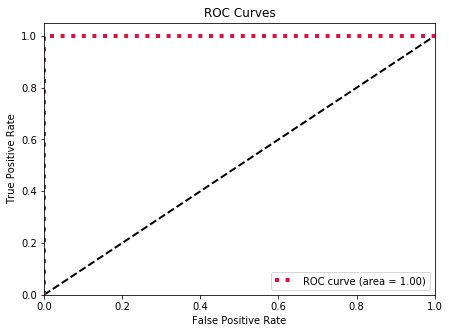



Training Loss Min: 0.388 in epoch 9, Max: 0.675, Current: 0.388
Validation Loss Min: 0.136 in epoch 7, Max: 0.351, Current: 0.170


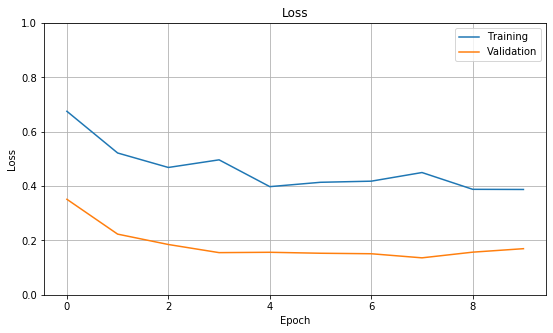



Training Accuracy Min: 0.590, Max: 0.845 in epoch 8, Current: 0.839
Validation Accuracy Min: 0.912, Max: 1.000 in epoch 2, Current: 0.975


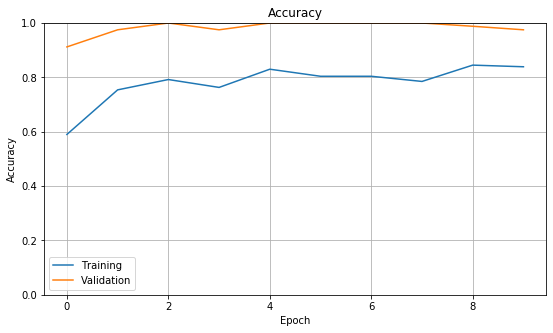



Training Cohen Kappa Min: 0.179, Max: 0.690 in epoch 8, Current: 0.677
Validation Cohen Kappa Min: 0.825, Max: 1.000 in epoch 2, Current: 0.950


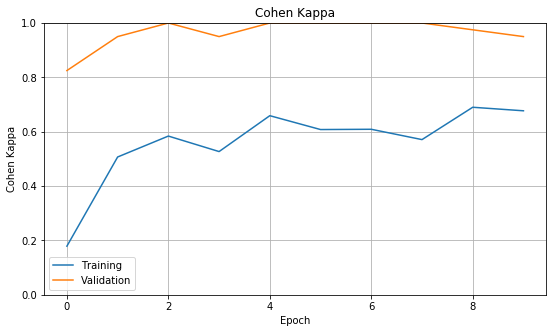



Training F1-Score Min: 0.590, Max: 0.845 in epoch 8, Current: 0.839
Validation F1-Score Min: 0.912, Max: 1.000 in epoch 2, Current: 0.975


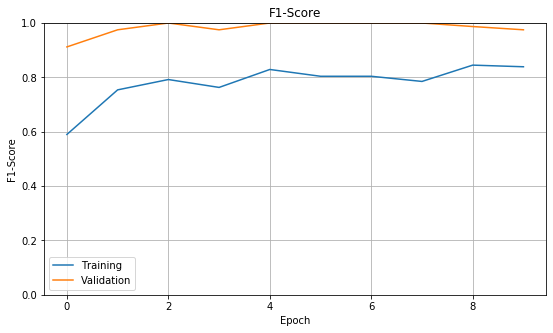



Training Precision Min: 0.590, Max: 0.846 in epoch 8, Current: 0.840
Validation Precision Min: 0.914, Max: 1.000 in epoch 2, Current: 0.976


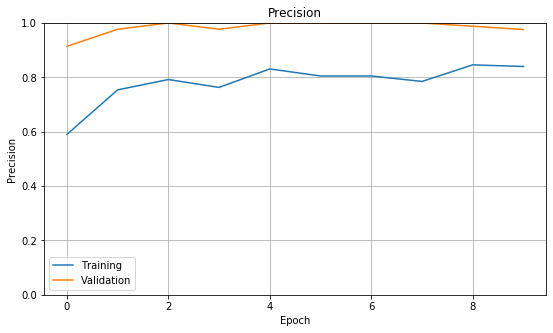



Training Recall Min: 0.590, Max: 0.845 in epoch 8, Current: 0.838
Validation Recall Min: 0.913, Max: 1.000 in epoch 2, Current: 0.976


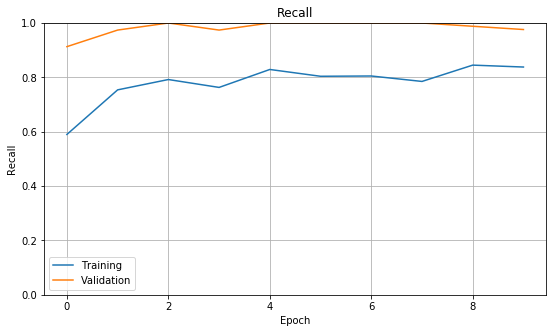



Training Specificity Min: 0.590, Max: 0.845 in epoch 8, Current: 0.838
Validation Specificity Min: 0.913, Max: 1.000 in epoch 2, Current: 0.976


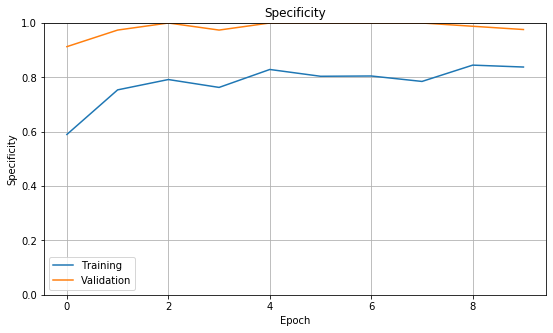

One epoch takes 0 [m] 11 [s]


In [0]:
# Training loop (Consider val_acc as the mertic to be followed)
# This function will show updated training dashboard during the model training
# This function will create a pickle file contains the best model and the evaluation metrics
model_training.loop(dataset, best = 'val_acc', reset_epoch_cnt=True)

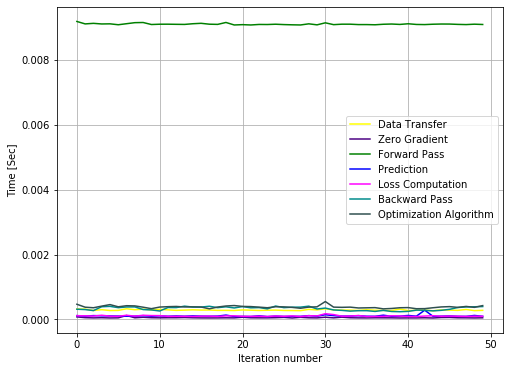

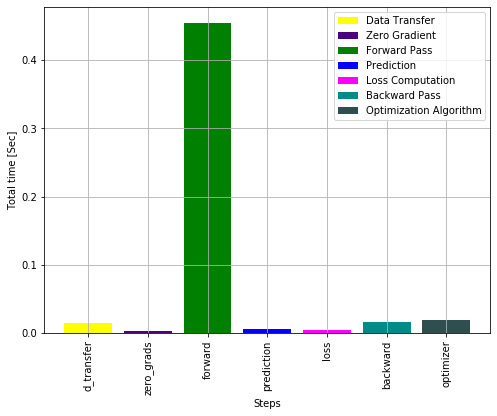

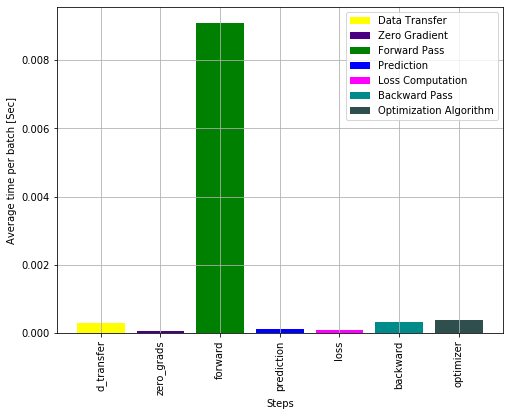

In [0]:
# Check each stage how much time it is consiuming for 50 iters
model_training.for_loop_timing(dataset, number_iters=50, show_time=False)
model_training.steps_timing_visualization()

In [0]:
# If you want to loop using while
model_training.while_loop_timing(dataset, number_iters=2, show_time=True)

Data loading takes 0.039751 [s]
Data transfer takes 0.000381 [s]
Zero gradients takes 0.000305 [s]
Forward takes 0.009279 [s]
Prediction takes 0.000391 [s]
Loss takes 0.000354 [s]
Backward takes 0.000668 [s]
Optimizer takes 0.000722 [s]
--------------------
Data loading takes 0.036549 [s]
Data transfer takes 0.000332 [s]
Zero gradients takes 0.000243 [s]
Forward takes 0.009236 [s]
Prediction takes 0.000298 [s]
Loss takes 0.00044 [s]
Backward takes 0.000548 [s]
Optimizer takes 0.000676 [s]
--------------------


In [0]:
# If you want to extract the model only in .pth file
ModelTraining.pth_model_save(model_training.model_name + '.pkl', 'test.pth')  


In [0]:
# If you want to create a compressed version of your model for deployment purpose
ModelTraining.compress_model_file('test.pth')

In [0]:
# If you want to show the missclassified samlpes
# display misclassified images
model_training.display_misclassification(model_training.model_name + '.pkl', dataset, to_display = 15)